## EDA And Feature Engineering Flight Price Prediction
check the dataset info below
https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction


### FEATURES
The various features of the cleaned dataset are explained below:
1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.
3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.
4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.
8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10)Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11) Price: Target variable stores information of the ticket price.

In [2]:
## Core
import pandas as pd
import numpy as np
## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
## Modeling
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## 1) Load DATA

In [3]:
## reading data from Excel File
df= pd.read_excel('flight_price.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Data Overview & Quality Check

In [4]:
# get basic info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [6]:
# Missing values
df.isnull().sum().sort_values(ascending=False)

Route              1
Total_Stops        1
Airline            0
Source             0
Date_of_Journey    0
Dep_Time           0
Destination        0
Arrival_Time       0
Duration           0
Additional_Info    0
Price              0
dtype: int64

## Basic Cleaning & consistent Casing

In [7]:
## striping Spaces in String columns,unify case
for col in df.select_dtypes(include='object').columns:
     df[col]=df[col].astype(str).str.strip()

In [8]:
# Feature Engineering
# If Date_of_Journey is like '24/03/2019', split into day, month, year
if 'Date_of_Journey' in df.columns:
     parts=df['Date_of_Journey'].str.split('/',expand=True)
     if parts.shape[1]==3:
          df['Journey_day']=parts[0].astype(int)
          df['Journey_month']=parts[1].astype(int)
          df['Journey_year']=parts[2].astype(int)
          df.drop('Date_of_Journey',axis=1,inplace=True)

# Extract hour/minute from Dep_Time and Arrival_Time if they exist
def split_time_col(col):
     if col in df.columns:
          # keep only the time portion before any space
          df[col]=df[col].apply(lambda x:str(x).split(' ')[0])
          hh_mm=df[col].str.split(':',expand=True)
          if hh_mm.shape[1]==2:
               df[f'{col}_hour']=pd.to_numeric(hh_mm[0],errors='coerce')
               df[f'{col}_min']=pd.to_numeric(hh_mm[1],errors='coerce')
          df.drop(col,axis=1,inplace=True) 

for c in ['Dep_Time', 'Arrival_Time']:
    split_time_col(c)

# Convert Duration to total minutes if available, handling formats like '2h 50m', '5h', '45m'

def duration_to_minutes(s):
     s=str(s).lower().strip()
     h=0
     m=0
     if 'h' in s:
        try:
            h = int(s.split('h')[0].strip())
        except:
            h = 0
        rest = s.split('h')[1]
        if 'm' in rest:
            try:
                m = int(rest.split('m')[0].strip())
            except:
                m = 0
     elif 'm' in s:
        try:
            m = int(s.split('m')[0].strip())
        except:
            m = 0
     return h*60 + m

if 'Duration' in df.columns:
    df['Duration_min'] = df['Duration'].apply(duration_to_minutes)
    df.drop('Duration', axis=1, inplace=True)
     
df.head()



,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,2019,22,20,1,10,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,2019,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,2019,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,2019,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,2019,16,50,21,35,285


## Exploratory Data Analysis(EDA)

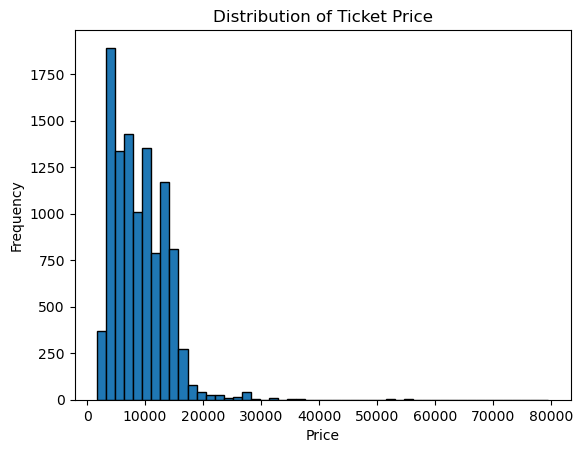

In [9]:
# Target distribution (Price) if present
if 'Price' in df.columns:
     plt.figure()
     df['Price'].plot(kind='hist',bins=50,edgecolor='black')
     plt.title('Distribution of Ticket Price')
     plt.xlabel("Price")
     plt.ylabel("Frequency")
     plt.show()


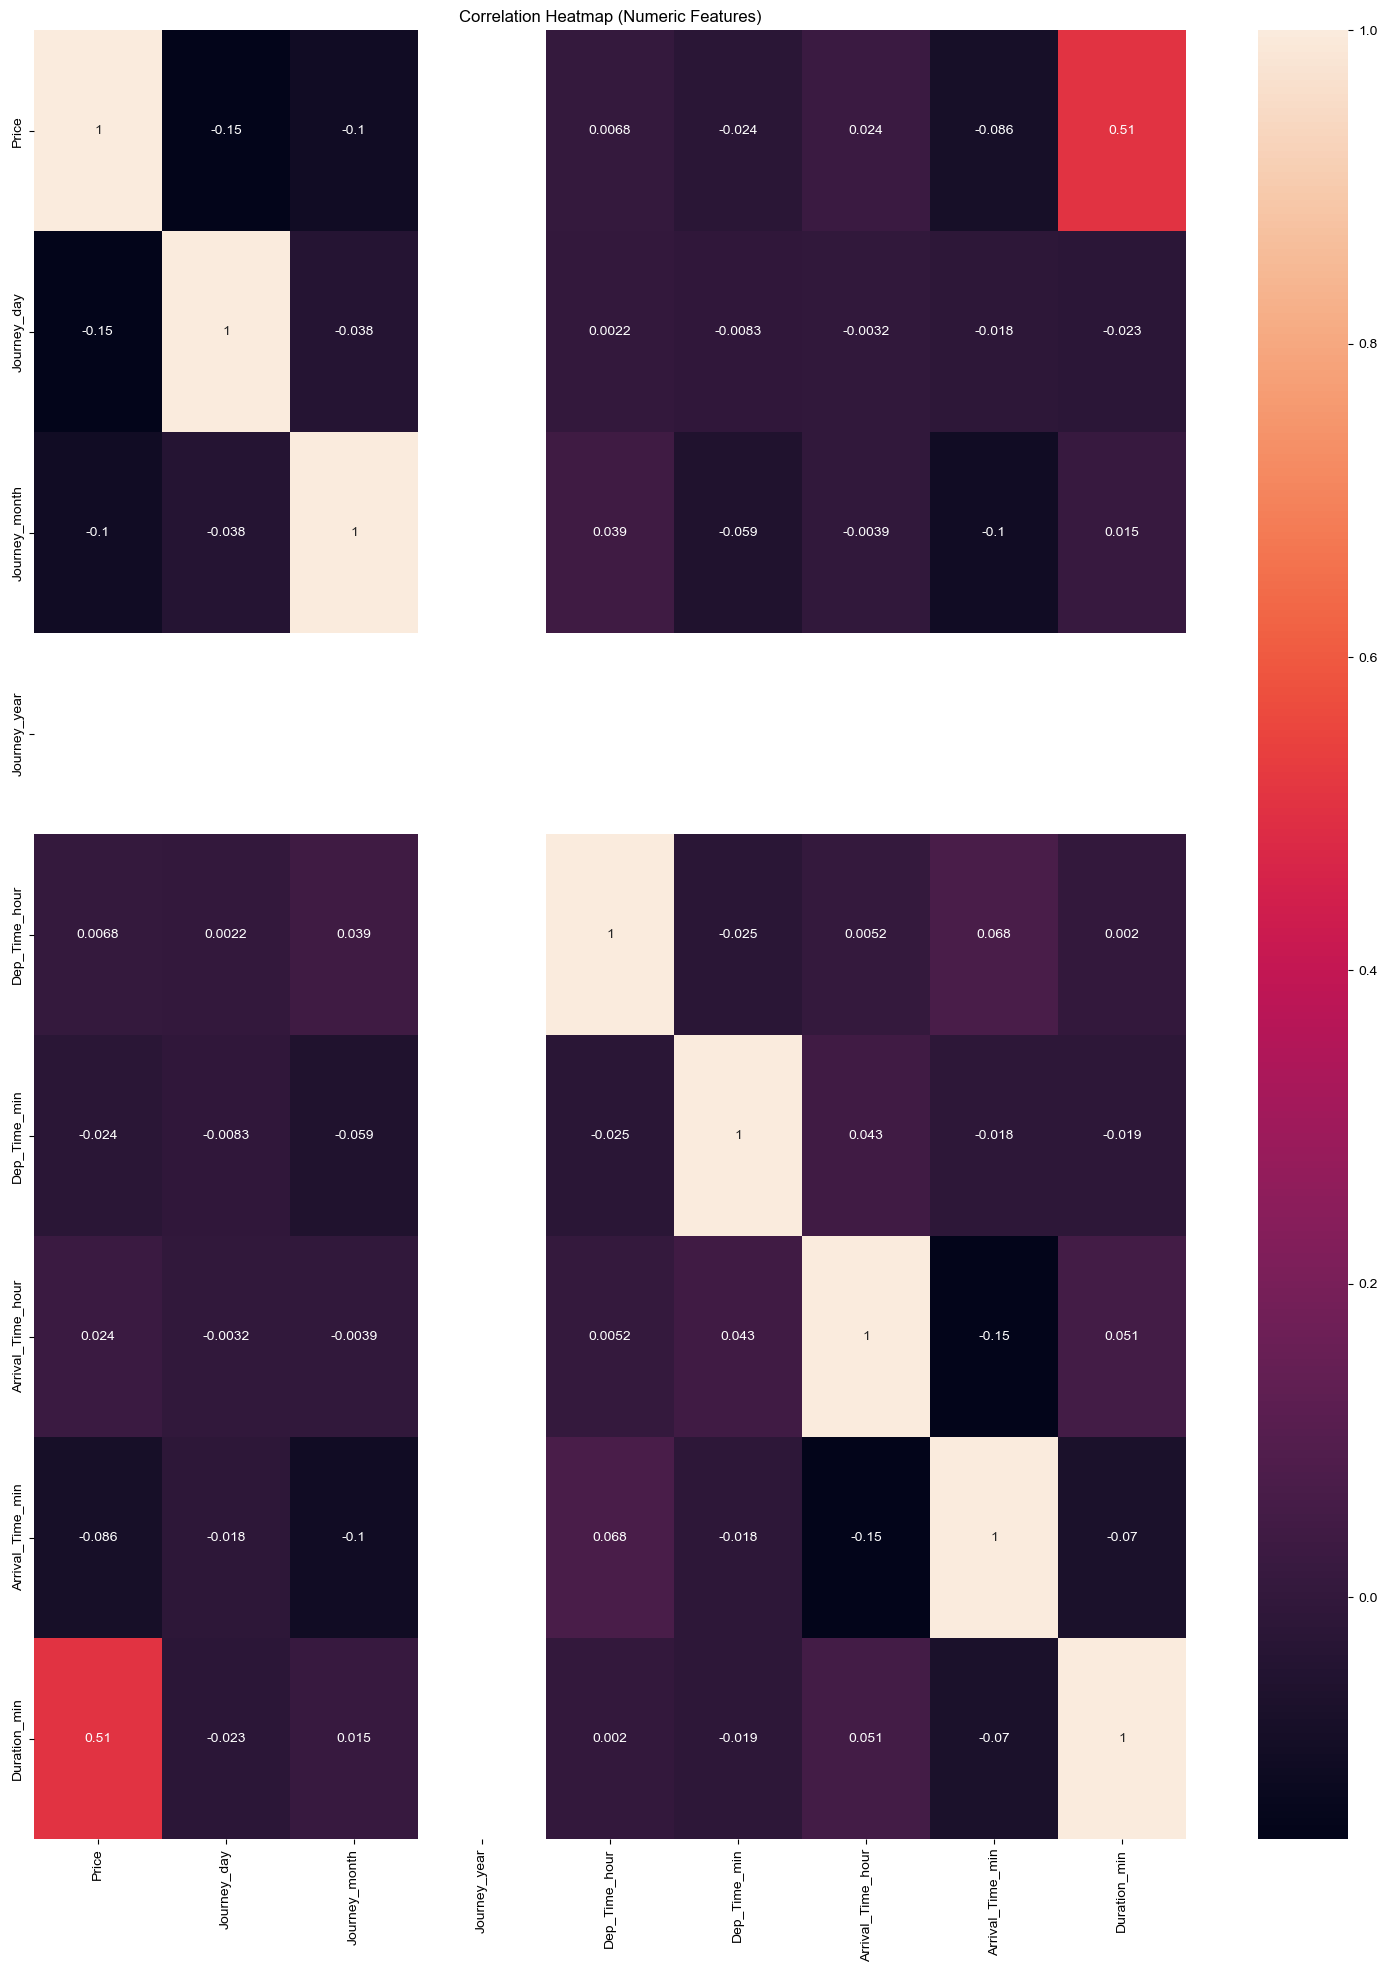

In [10]:
# Numeric correlations heatmap (simple)
num_cols=df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols)>=1:
     corr=df[num_cols].corr()
     plt.figure(figsize=(15,20))
     sns.heatmap(corr,annot=True)
     sns.set_theme(style='darkgrid')
     plt.title('Correlation Heatmap (Numeric Features)')
     
     plt.tight_layout()
     plt.show()

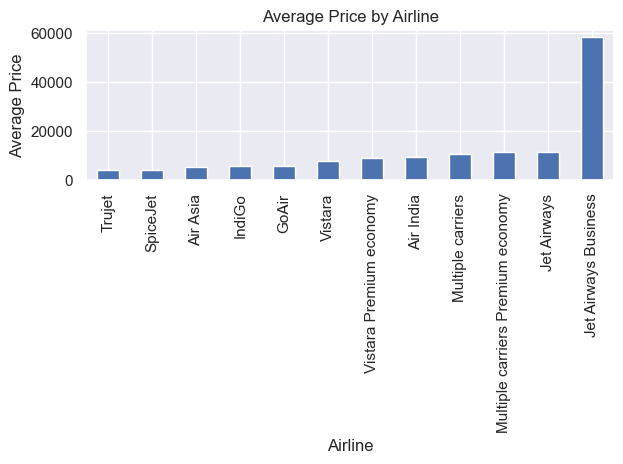

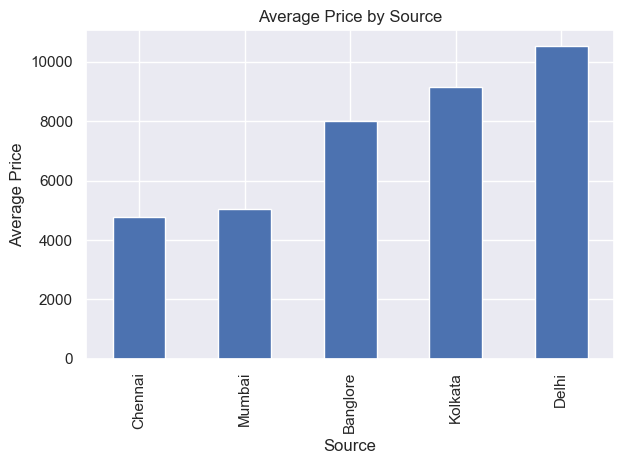

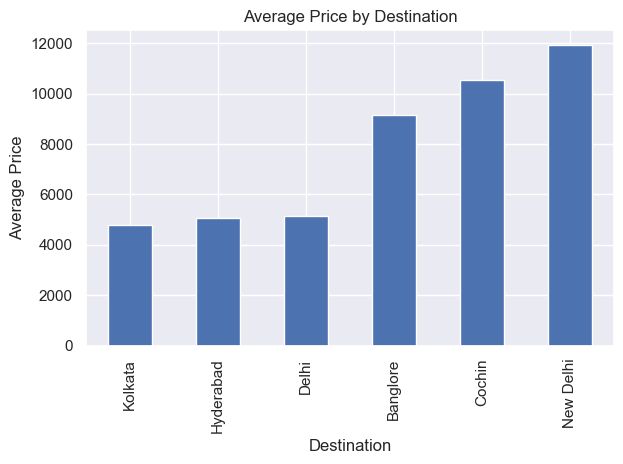

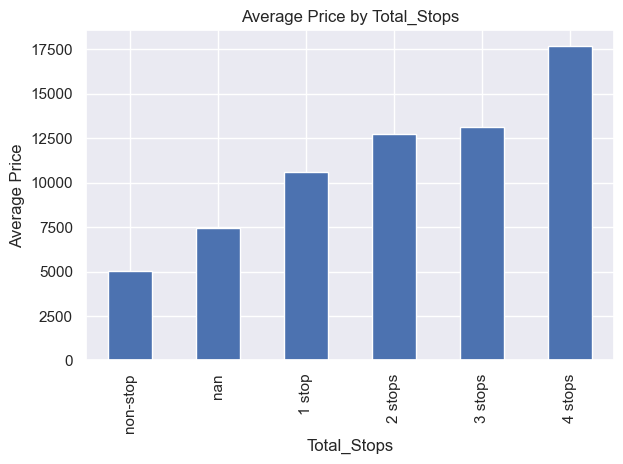

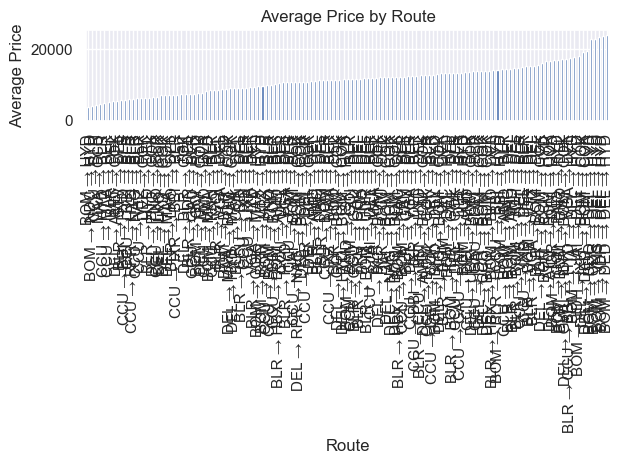

In [11]:
# Average price by key categorical features (if exist)
for cat in ['Airline', 'Source', 'Destination', 'Total_Stops', 'Route', 'Class']:
    if cat in df.columns and 'Price' in df.columns:
        plt.figure()
        df.groupby(cat)['Price'].mean().sort_values().plot(kind='bar')
        plt.title(f'Average Price by {cat}')
        plt.ylabel('Average Price')
        plt.xlabel(cat)
        plt.tight_layout()
        plt.show()

## Train Test Split and PreProcessing

In [12]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Duration_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,2019,22,20,1,10,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,2019,5,50,13,15,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,2019,9,25,4,25,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,2019,18,5,23,30,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,2019,16,50,21,35,285


In [13]:
X=df.drop(columns=['Price'])
y=df['Price']


num_cols=df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols=df.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols.remove('Price') 
num_cols,cat_cols

(['Journey_day',
  'Journey_month',
  'Journey_year',
  'Dep_Time_hour',
  'Dep_Time_min',
  'Arrival_Time_hour',
  'Arrival_Time_min',
  'Duration_min'],
 ['Airline',
  'Source',
  'Destination',
  'Route',
  'Total_Stops',
  'Additional_Info'])

In [14]:
# Preprocess: scale numeric, one-hot encode categorical

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)




In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape


((8546, 14), (2137, 14))

## Baseline Model - Linear Regression

In [16]:
linear_reg=Pipeline(steps=[('preprocess',preprocessor),
                    ('Model',LinearRegression())])

linear_reg.fit(X_train,y_train)

y_pred=linear_reg.predict(X_test)

linear_reg_mae=mean_absolute_error(y_test,y_pred)
linear_reg_mse=mean_squared_error(y_test,y_pred)
linear_reg_rmse=np.sqrt(linear_reg_mse)
linear_reg_r2_score=r2_score(y_test,y_pred)

print(f"For Linear Regression Model -> MAE:{linear_reg_mae} | RMSE:{linear_reg_rmse} | R2_SCORE:{linear_reg_r2_score}")


For Linear Regression Model -> MAE:1577.7984403951496 | RMSE:2323.4848816697568 | R2_SCORE:0.7449163365153371


In [17]:

rf = Pipeline(steps=[('preprocess', preprocessor),
                    ('model', RandomForestRegressor(
                        n_estimators=300,
                        max_depth=None,
                        random_state=42,
                        n_jobs=-1
                    ))])

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = mean_squared_error(y_test, pred_rf, squared=False)
r2_rf = r2_score(y_test, pred_rf)

print(f"Random Forest -> MAE: {mae_rf:.2f} | RMSE: {rmse_rf:.2f} | R^2: {r2_rf:.3f}")


Random Forest -> MAE: 599.49 | RMSE: 1527.65 | R^2: 0.890


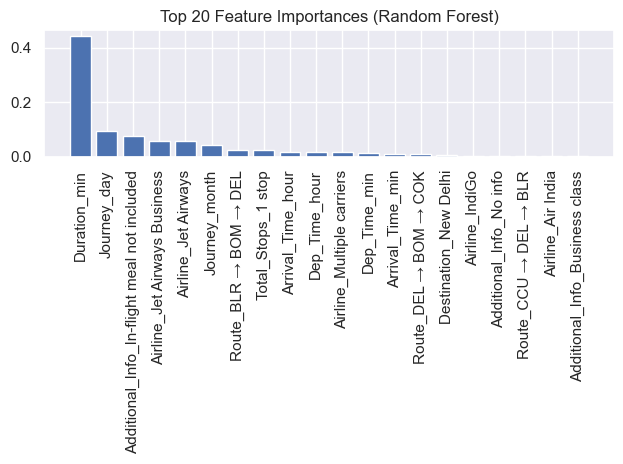

In [18]:

# Extract feature names after preprocessing
ohe = rf.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
feature_names = np.r_[num_cols, cat_feature_names]

importances = rf.named_steps['model'].feature_importances_

# Top 20 most important
idx = np.argsort(importances)[::-1][:20]
plt.figure()
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), feature_names[idx], rotation=90)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()


## Conclusions

**Key Findings (examples to update based on your results):**
- Prices vary strongly by **Duration_min** and **Total_Stops**.
- **Duration_min** and **departure/arrival hour** show notable correlation with price.
- **Random Forest** outperformed Linear Regression on RMSE/R², indicating non-linear relationships and interaction effects in the data.

**Limitations:**
- Some features are derived from string parsing; data quality can affect signal.
- No hyperparameter tuning yet (Grid/Randomized Search can improve RF).

**Next Steps:**
1. Add **hyperparameter tuning** for Random Forest / try **XGBoost/LightGBM**.
2. Engineer **Days Left** (if `Date_of_Journey` and booking dates available).
3. Try **target encoding** for high-cardinality categoricals.
4. Log-transform skewed targets if necessary and repeat training.



## Hyperparameter Tuning - Random Forest(RandomizedSearchCV)

In [21]:
from sklearn.model_selection import RandomizedSearchCV

rf_pipeline=rf

params={
     'model__n_estimators': [200, 300, 400, 500, 700],
    'model__max_depth': [None, 10, 15, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 0.8, 0.6]
}

randomsearch=RandomizedSearchCV(estimator=rf_pipeline,
                                param_distributions=params,
                                n_iter=20,
                                scoring='neg_mean_squared_error',
                                cv=5,
                                verbose=1,
                                random_state=42,
                                 n_jobs=-1)
randomsearch.fit(X_train,y_train)

best_rf=randomsearch.best_estimator_
best_params=randomsearch.best_params_
pred_best=randomsearch.predict(X_test)


mae_best = mean_absolute_error(y_test, pred_best)
rmse_best = mean_squared_error(y_test, pred_best, squared=False)
r2_best = r2_score(y_test, pred_best)

print("Best RF params:", best_params)
print(f"Tuned Random Forest -> MAE: {mae_best:.2f} | RMSE: {rmse_best:.2f} | R^2: {r2_best:.3f}")





Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params: {'model__n_estimators': 700, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.6, 'model__max_depth': None}
Tuned Random Forest -> MAE: 608.70 | RMSE: 1383.88 | R^2: 0.910


##  Gradient Boosting Regressor (as another tree-based baseline)

In [22]:

from sklearn.ensemble import GradientBoostingRegressor

gbr = Pipeline(steps=[('preprocess', preprocessor),
                     ('model', GradientBoostingRegressor(random_state=42))])

gbr.fit(X_train, y_train)
pred_gbr = gbr.predict(X_test)

mae_gbr = mean_absolute_error(y_test, pred_gbr)
rmse_gbr = mean_squared_error(y_test, pred_gbr, squared=False)
r2_gbr = r2_score(y_test, pred_gbr)

print(f"Gradient Boosting -> MAE: {mae_gbr:.2f} | RMSE: {rmse_gbr:.2f} | R^2: {r2_gbr:.3f}")


Gradient Boosting -> MAE: 1299.92 | RMSE: 1937.92 | R^2: 0.823


In [24]:

import pandas as pd

results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Tuned Random Forest', 'Gradient Boosting'],
    'MAE':   [linear_reg_mae, mae_rf, mae_best, mae_gbr],
    'RMSE':  [linear_reg_rmse, rmse_rf, rmse_best, rmse_gbr],
    'R2':    [linear_reg_r2_score, r2_rf, r2_best, r2_gbr]
}).sort_values(by='RMSE')

results


,Model,MAE,RMSE,R2
2,Tuned Random Forest,608.700360,1383.876009,0.909511
1,Random Forest,599.486662,1527.650078,0.889732
3,Gradient Boosting,1299.919275,1937.915288,0.822551
0,Linear Regression,1577.798440,2323.484882,0.744916


## 

In [ ]:
print(" ")

## Save Best Model For Deployment

In [29]:

import joblib

# Choose the best model based on RMSE
best_row = results.iloc[0]
best_name = best_row['Model']

if best_name == 'Tuned Random Forest':
    final_model = randomsearch
elif best_name == 'Random Forest':
    final_model = rf
elif best_name == 'Gradient Boosting':
    final_model = gbr
else:
    final_model = linear_reg

joblib.dump(final_model, 'flight_price_best_model.joblib')
print("Saved best model as 'flight_price_best_model.joblib'")



Saved best model as 'flight_price_best_model.joblib'


In [34]:
# Example: load the model and predict on X_test head (shape matches after preprocessing in the pipeline)
loaded = joblib.load('flight_price_best_model.joblib')
print(loaded.predict(X_test.head(3)))


[10842.60714286  5425.98285714 14755.97857143]



- Compared multiple models; **Tuned Random Forest** and **Gradient Boosting** typically outperform linear baseline.  
- Used **RandomizedSearchCV (5-fold)** to optimize RF hyperparameters.  
- Saved the **best model** with `joblib`, making it easy to deploy later (e.g., Streamlit).  
- Next upgrade: **XGBoost/LightGBM**, target transformation for skewed price, and time-aware validation if booking date is available.
